In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Read the CSV file with the correct 'thousands' parameter to handle commas
stock_data = pd.read_csv('/content/drive/MyDrive/CSE All-Share Historical Data (1).csv', thousands=',')

UnicodeDecodeError: ignored

In [ ]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')

In [ ]:
stock_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-07-24,11073.01,11106.54,11116.46,11068.57,78.45M,-0.30%
1,2023-07-21,11106.54,11026.83,11106.54,10979.21,117.44M,0.76%
2,2023-07-20,11023.02,10927.29,11033.40,10916.04,156.51M,0.75%
3,2023-07-19,10940.82,10796.07,10946.98,10769.25,182.58M,1.34%
4,2023-07-18,10796.07,10727.99,10825.90,10657.51,131.22M,0.63%


In [ ]:
# These are the libraries we are going to use
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

#Data Preprocessing

In [ ]:
target_y = stock_data['Price']
X_feat = stock_data.iloc[:,0:3]

In [ ]:
# Convert the 'Price' column to numeric values by directly converting to float
stock_data['Price'] = stock_data['Price'].astype(float)

# Now proceed with the feature scaling as before, excluding the 'Date' column
X_feat = stock_data.iloc[:, 1:4]

# Feature Scaling
sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)


#Train and test sets for stock price prediction

In [ ]:
def lstm_split(data, n_steps):
  X, y =[], []
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

In [ ]:
X1, y1 = lstm_split(X_ft.values, n_steps=2)

train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(919, 2, 2) (736, 2, 2) (183, 2, 2) (183,)


#Building the LSTM model

In [ ]:
lstm =  Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer ='adam')
lstm.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 32)             4480      
                                                                 
 dense_10 (Dense)            (None, 2, 1)              33        
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
184/184 - 1s - loss: 0.4447 - 1s/epoch - 6ms/step
Epoch 2/100
184/184 - 0s - loss: 0.1546 - 264ms/epoch - 1ms/step
Epoch 3/100
184/184 - 0s - loss: 0.0653 - 251ms/epoch - 1ms/step
Epoch 4/100
184/184 - 0s - loss: 0.0213 - 249ms/epoch - 1ms/step
Epoch 5/100
184/184 - 0s - loss: 0.0091 - 251ms/epoch - 1ms/step
Epoch 6/100
184/184 - 0s - loss: 0.0089 - 247ms/epoch - 1ms/step
Epoch 7/100
184/184 - 0s - loss: 0.0089 - 245ms/epoch - 1ms/step
Epoch 8/100
184/184 - 0s - loss: 0.0090 - 250ms/epoch - 1ms/step
Epoch 9/100
184/184 - 0s - loss: 0.0091 - 279ms/epoch - 2ms/step
Epoch 10/100
184/184 - 0s - loss: 0.0092 - 330ms/epoch - 2ms/step
Epoch 11/100
184/184 - 0s - loss: 0.0093 - 364ms/epoch - 2ms/step
Epoch 12/100
184/184 - 0s - loss: 0.0095 - 329ms/epoch - 2ms/step
Epoch 13/100
184/184 - 0s - loss: 0.0097 - 322ms/epoch - 2ms/step
Epoch 14/100
184/184 - 0s - loss: 0.0101 - 317ms/epoch - 2ms/step
Epoch 15/100
184/184 - 0s - loss: 0.0106 - 313ms/epoch - 2ms/step
Epoch 16/100
184/184 -

In [ ]:
y_pred = lstm.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [ ]:
# Trim y_pred to match the length of y_test
y_pred_trimmed = y_pred[:len(y_test)]

# Calculate RMSE and MAPE for all predicted values together
rmse = np.sqrt(mean_squared_error(y_test, y_pred_trimmed))
mape = np.mean(np.abs((y_test - y_pred_trimmed) / y_test)) * 100

print("RMSE: ", rmse)
print("MAPE: ", mape)


RMSE:  0.1620422238472241
MAPE:  28.67864070878564


#Deeper LSTM model

In [ ]:
# Create and compile the LSTM model
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

# Train the LSTM model
history = lstm.fit(X_train, y_train, epochs=50, batch_size=4, verbose=2, shuffle=False)

# Make predictions using the trained model
y_pred = lstm.predict(X_test)

# Calculate RMSE and MAPE for the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("RMSE: ", rmse)
print("MAPE: ", mape)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 2, 50)             10600     
                                                                 
 lstm_16 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
184/184 - 2s - loss: 0.1676 - 2s/epoch - 9ms/step
Epoch 2/50
184/184 - 0s - loss: 0.0252 - 326ms/epoch - 2ms/step
Epoch 3/50
184/184 - 0s - loss: 0.0152 - 337ms/epoch - 2ms/step
Epoch 4/50
184/184 - 0s - loss: 0.0116 - 329ms/epoch - 2ms/step
Epoch 5/50
184/184 - 0s - loss: 0.0104 - 341ms/epoch - 2ms/s

In [ ]:
n_steps=10
X1, y1 = lstm_split(X_ft.values, n_steps=2)

train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape,X_test_date.shape, y_test.shape)

(919, 2, 2) (736, 2, 2) (183, 2, 2) (184,) (183,)


In [ ]:
# Trim y_pred to match the length of y_test
y_pred_trimmed = y_pred[:len(y_test)]

# Calculate RMSE and MAPE for all predicted values together
rmse = np.sqrt(mean_squared_error(y_test, y_pred_trimmed))
mape = np.mean(np.abs((y_test - y_pred_trimmed) / y_test)) * 100

print("RMSE: ", rmse)
print("MAPE: ", mape)


RMSE:  0.1620422238472241
MAPE:  28.67864070878564


#Simple Moving Average

In [ ]:
# Read the CSV file with the correct 'thousands' parameter to handle commas
stock_data = pd.read_csv('/content/drive/MyDrive/CSE All-Share Historical Data (1).csv', thousands=',')

In [ ]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')

In [ ]:
target_y = stock_data['Price']
X_feat = stock_data.iloc[:,0:3]

In [ ]:
# Convert the 'Price' column to numeric values by directly converting to float
stock_data['Price'] = stock_data['Price'].astype(float)

# Now proceed with the feature scaling as before, excluding the 'Date' column
X_feat = stock_data.iloc[:, 1:4]

# Feature Scaling
sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)


Test RMSE: 749.145
Test MAPE: 0.122


<function matplotlib.pyplot.show(close=None, block=None)>

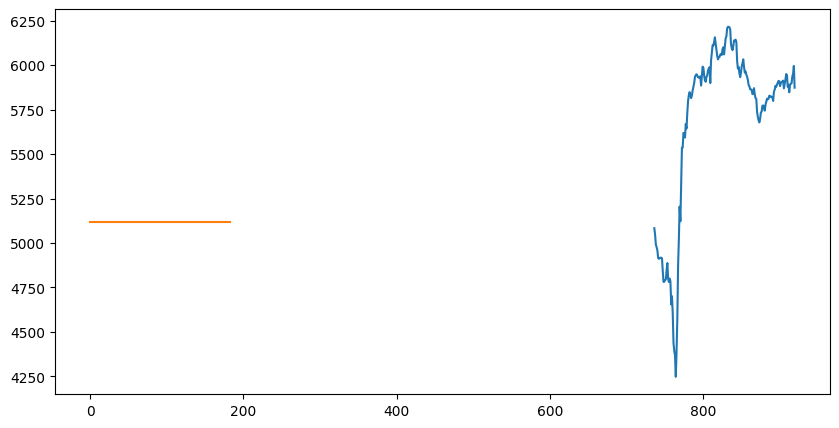

In [ ]:
train_split = 0.8
split_idx = int(np.ceil(len(stock_data)*train_split))
train = stock_data[['Price']].iloc[:split_idx]
test = stock_data[['Price']].iloc[split_idx:]

test_pred = np.array([train.rolling(10).mean().iloc[-1]]*len(test)).reshape((-1,1))

print('Test RMSE: %.3f' % mean_squared_error(test, test_pred, squared=False))
print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_pred))

plt.figure(figsize=(10,5))
plt.plot(test)
plt.plot(test_pred)
plt.show

#Exponential Moving Average

Test RMSE: 749.629
Test MAPE: 0.122


<function matplotlib.pyplot.show(close=None, block=None)>

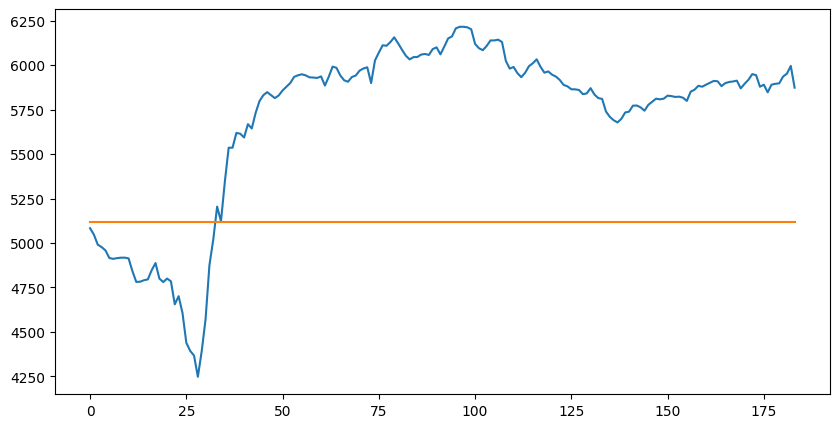

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

X = stock_data[['Price']].values
train_split= 0.8
split_idx = int(np.ceil(len(X)*train_split))
train = X[:split_idx]
test = X[split_idx:]
test_concat = np.array([]).reshape((0,1))

for i in range(len(test)):
  train_fit = np.concatenate((train, np.asarray(test_concat)))
  fit = SimpleExpSmoothing(np.asarray(train_fit)).fit(smoothing_level=0.2)
  test_pred = fit.forecast(1)
  test_concat = np.concatenate((np.asarray(test_concat),test_pred.reshape((-1,1))))

print('Test RMSE: %.3f' % mean_squared_error(test, test_concat, squared=False))
print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_concat))

plt.figure(figsize=(10,5))
plt.plot(test)
plt.plot(test_concat)
plt.show